# Task 6: Landmark detection

In [1]:
import cv2
import matplotlib.pyplot as plt
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from skimage.morphology import skeletonize
from skan import draw
import numpy as np
from skimage.util import invert
import networkx as nx

In [2]:
im_num = 6
im = 4

In [3]:
im_root = cv2.imread(f"../plants/segmented_roots/im{im_num}/{im}_output_root.png")
im_root = im_root * 255
real_im = cv2.imread(f"../plants/segmented_roots/im{im_num}/{im}_img.png")

In [4]:
from skimage.morphology import remove_small_objects

skeleton = skeletonize(im_root)

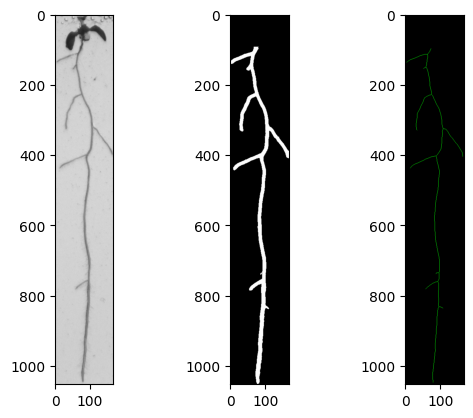

In [5]:
fig, ax = plt.subplots(1, 3)


ax[0].imshow(real_im)
ax[1].imshow(im_root)
ax[2].imshow(skeleton)

plt.show()

In [6]:
simple_skeleton_branch_data = summarize(Skeleton(skeleton))
G = nx.from_pandas_edgelist(simple_skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
simple_skeleton_branch_data_clean = simple_skeleton_branch_data[['skeleton-id', 'node-id-src', 'node-id-dst', 'branch-distance',
       'branch-type',
       'image-coord-src-0', 'image-coord-src-1',
       'image-coord-dst-0', 'image-coord-dst-1',
       'coord-src-0', 'coord-src-1', 'coord-dst-0',
       'coord-dst-1','euclidean-distance']]

In [7]:
x = []
y = []
branches = len(simple_skeleton_branch_data)
im_with_circles = real_im.copy()
end_root_index = simple_skeleton_branch_data.sort_values(by="node-id-dst", ascending=True)["node-id-dst"][branches - 1]
sub_roots = []
sub_root_paths = []
sub_root_index = []

for i in range(branches):
    if i == 0:
        # Check if it's the first node.
        x = simple_skeleton_branch_data["image-coord-src-0"][i]
        y = simple_skeleton_branch_data["image-coord-src-1"][i]
        im_with_circles = cv2.circle(im_with_circles, (y, x), 10, (0, 255, 0), 2)
        start_node = simple_skeleton_branch_data["node-id-src"][i]
    else:
        if simple_skeleton_branch_data["node-id-dst"][i] == end_root_index:
            # Check if its the last root
            x = simple_skeleton_branch_data["image-coord-dst-0"][i]
            y = simple_skeleton_branch_data["image-coord-dst-1"][i]
            im_with_circles = cv2.circle(im_with_circles, (y, x), 10, (0, 0, 0), 2)  
            end_node = simple_skeleton_branch_data["node-id-dst"][i]         
        else:
            if(simple_skeleton_branch_data["branch-type"][i] == 1) and (simple_skeleton_branch_data["branch-distance"][i] > 25):
            #if(simple_skeleton_branch_data["branch-distance"][i] > 25):
                # Circle the junction points together with their end.
                x = simple_skeleton_branch_data["image-coord-src-0"][i]
                y = simple_skeleton_branch_data["image-coord-src-1"][i]
                x_end = simple_skeleton_branch_data["image-coord-dst-0"][i]
                y_end = simple_skeleton_branch_data["image-coord-dst-1"][i]
                sub_start_node = simple_skeleton_branch_data["node-id-src"][i]
                sub_end_node = simple_skeleton_branch_data["node-id-dst"][i]
                im_with_circles = cv2.circle(im_with_circles, (y, x), 10, (255, 0, 0), 2)
                im_with_circles = cv2.circle(im_with_circles, (y_end, x_end), 10, (0, 0, 255), 2)
                sub_roots.append(nx.dijkstra_path_length(G, sub_end_node, sub_start_node, weight='branch-distance'))
                sub_root_paths.append(nx.dijkstra_path(G, sub_end_node, sub_start_node, weight='branch-distance'))
                sub_root_index.append(simple_skeleton_branch_data.index[i])
sub_roots = np.array(sub_roots)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

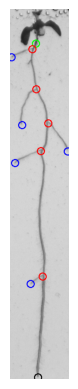

In [8]:
plt.imshow(im_with_circles)
plt.axis("off")
plt.plot

MAE
MAPE
SMAPE

In [9]:
path_len = nx.dijkstra_path_length(G, end_node, start_node, weight='branch-distance')
path_len

1020.1736649163071

In [10]:
print(f"Amount of subroots: {len(sub_root_index)}")

Amount of subroots: 5


In [11]:
simple_skeleton_branch_data.iloc[sub_root_index]

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
1,0,24,97,68.526912,1,1.0,0.0,114,63,1,137,4,1,114,63,1,137,4,1,63.324561
5,0,196,417,126.325902,1,1.0,0.0,228,74,1,330,34,1,228,74,1,330,34,1,109.562767
8,0,399,579,105.710678,1,1.0,0.0,325,108,1,405,163,1,325,108,1,405,163,1,97.082439
9,0,571,675,88.497475,1,1.0,0.0,404,87,1,438,14,1,404,87,1,438,14,1,80.529498
13,0,1010,1062,42.698485,1,1.0,0.0,761,92,1,782,58,1,761,92,1,782,58,1,39.962482


In [12]:
subroot_data = simple_skeleton_branch_data.iloc[sub_root_index]
subroot_data = subroot_data[["branch-distance", 'image-coord-src-0', 'image-coord-src-1', 'image-coord-dst-0', 'image-coord-dst-1', "euclidean-distance"]]
subroot_data =subroot_data.rename(columns={ "image-coord-src-0": "V1x", "image-coord-src-1":"V1y", "image-coord-dst-0":"V2x", "image-coord-dst-1":"V2y"})
subroot_data

,branch-distance,V1x,V1y,V2x,V2y,euclidean-distance
1,68.526912,114,63,137,4,63.324561
5,126.325902,228,74,330,34,109.562767
8,105.710678,325,108,405,163,97.082439
9,88.497475,404,87,438,14,80.529498
13,42.698485,761,92,782,58,39.962482


In [13]:
path = nx.dijkstra_path(G, start_node, end_node, weight='branch-distance')
node_coordinates = {}
for i in range(len(simple_skeleton_branch_data)):
    src_id = simple_skeleton_branch_data["node-id-src"][i]
    dst_id = simple_skeleton_branch_data["node-id-dst"][i]
    node_coordinates[src_id] = (simple_skeleton_branch_data["image-coord-src-1"][i], simple_skeleton_branch_data["image-coord-src-0"][i])
    node_coordinates[dst_id] = (simple_skeleton_branch_data["image-coord-dst-1"][i], simple_skeleton_branch_data["image-coord-dst-0"][i])
for i in range(len(path) - 1):
    point1 = node_coordinates[path[i]]
    point2 = node_coordinates[path[i + 1]]
    im_with_circles = cv2.line(im_with_circles, point1, point2, (0, 0, 255), 2)
for path in sub_root_paths:
    for i in range(len(path) - 1):
        point1 = node_coordinates[path[i]]
        point2 = node_coordinates[path[i + 1]]
        im_with_circles = cv2.line(im_with_circles, point1, point2, (0, 255, 255), 2)

<function matplotlib.pyplot.show(close=None, block=None)>

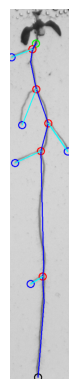

In [14]:
plt.imshow(im_with_circles)
plt.axis("off")
plt.show